<a href="https://colab.research.google.com/github/PabloDome/Microcopio/blob/main/BobinasHemholtz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

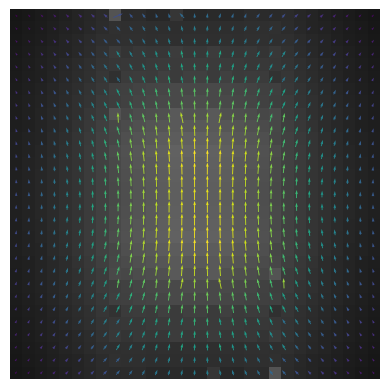

Text(0.5, 0, 'x (cm)')

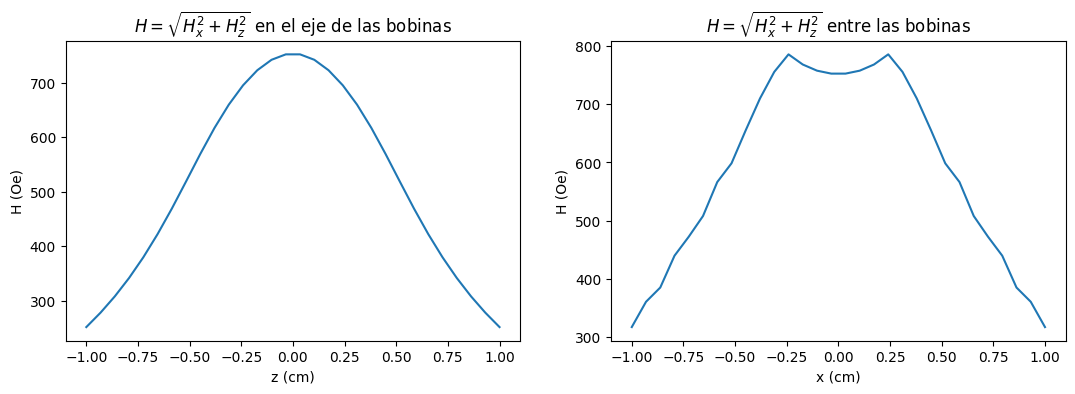

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tomo el eje z como el eje de las espiras

e = 0.05/100 # Diametro del alambre en m
N_bob = 30 # Cantidad de espiras en el plano xy
N_z = 10 # Cantidad de espiras en el eje z
Rad_bob = 0.3/100 # Radio de la bobina interna en m
Pos_max = 2/100 #Distancia maxima de zoneo en m
Tam = 30 #Tamaño de la discretización del espacio
I = 2 # Corriente en A
Bobina_Hemholtz = 0 # 0 Es una bobina simple que esta en el centro, 1 es un par de Hemholtz

B_x = np.zeros((Tam,Tam))
B_z = np.zeros((Tam,Tam))

Btot_x = np.zeros((Tam,Tam))
Btot_z = np.zeros((Tam,Tam))

B_punto = np.zeros(3)

def BS_x(ang, r_bob, r, Radio_bob):
  BiSav_x = (r_bob-r[2])*np.cos(ang)/(((r[0]-Radio_bob*np.cos(ang))**2+
                                                                 (r[1]-Radio_bob*np.sin(ang))**2+
                                                                 (r_bob-r[2])**2)**1.5)
  return BiSav_x

def BS_y(ang, r_bob, r, Radio_bob):
  BiSav_y = (-r_bob+r[2])*np.sin(ang)/(((r[0]-Radio_bob*np.cos(ang))**2+
                                                                 (r[1]-Radio_bob*np.sin(ang))**2+
                                                                 (r_bob-r[2])**2)**1.5)
  return BiSav_y

def BS_z(ang, r_bob, r, Radio_bob):
  BiSav_z = (Radio_bob-r[1]*np.sin(ang)-r[0]*np.cos(ang))/(((r[0]-Radio_bob*np.cos(ang))**2+
                                                                 (r[1]-Radio_bob*np.sin(ang))**2+
                                                                 (r_bob-r[2])**2)**1.5)
  return BiSav_z

def BitSabart(I, r, r_bob, Radio_bob): #Es necesario que Radio_bob este en m
  # Por practicidad voy a calcular el campo en xz, pero agregando la linea comentada se puede hacer en 3d
  C = 10000*10**(-7)*I*Radio_bob
  theta = np.linspace(0, 2*np.pi, num=500, endpoint=True) # num es la cantidad de divisiones de integración

  Bx = C*np.trapz(BS_x(theta, r_bob, r, Radio_bob),theta)
  By = 0 # C*np.trapz(BS_y(theta, r_bob, r, Radio_bob),theta)
  Bz = C*np.trapz(BS_z(theta, r_bob, r, Radio_bob),theta)

  B = np.array([Bx, 0, Bz])

  return B

def Espira_punto(r, pos_bob):

  B_p = np.zeros(3)

  for i in range(N_bob):
    for j in range(N_z):
      B_p = B_p + BitSabart(I, r, pos_bob+j*e, Rad_bob+i*e)

  return  B_p


def Bobina():
  B_x = np.zeros((Tam,Tam))
  B_z = np.zeros((Tam,Tam))

  Posicion_x = np.linspace(-Pos_max*0.5, Pos_max*0.5, num=Tam)
  Posicion_z = np.linspace(-Pos_max*0.5, Pos_max*0.5, num=Tam)

  for i in range(Tam):
    for j in range(Tam):
      r = np.array([Posicion_x[i], 0, Posicion_z[j]])

      if Bobina_Hemholtz == 1:
        z_0 = Rad_bob*0.5
      else:
        z_0 = 0.0

      B_punto = Espira_punto(r, z_0)
      B_x[i,j] = B_punto[0]
      B_z[i,j] = B_punto[2]

  return B_x, B_z

def Espira_solucion_Analitica_ejeZ(eje): # esto es solo para chequear en caso de dudas
  Bz_ideal = eje*0
  C = 10000*10**(-7)*I*Rad_bob*Rad_bob*4*np.pi*0.5

  for i in range(len(eje)):
    Bz_ideal[i] = C/(((Rad_bob**2)+((eje[i]-Rad_bob*0.5)**2))**1.5)

  return Bz_ideal

B_x, B_z = Bobina()

B_x = np.nan_to_num(B_x)
B_z = np.nan_to_num(B_z)

if Bobina_Hemholtz == 1:
  Btot_x = B_x
  Btot_z = B_z
else:
  for i in range(Tam):
    for j in range(Tam):
      Btot_x[i,j] = B_x[i,j] + B_x[Tam-i-1,Tam-j-1]
      Btot_z[i,j] = B_z[i,j] + B_z[Tam-i-1,Tam-j-1]


Int_Campo = np.sqrt(Btot_x*Btot_x+Btot_z*Btot_z)
z, x = np.meshgrid(np.linspace(0, Tam, Tam), np.linspace(0, Tam, Tam))
plt.quiver(z, x, Btot_x, Btot_z, np.arctan(Btot_z/np.max(Btot_z)), pivot='mid',color='g')
plt.imshow(abs(Int_Campo*100/np.max(Int_Campo)), cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

fig = plt.figure()
fig.set_size_inches(10, 3)
fig.subplots_adjust(left = 0.0, right=1.0, bottom=0.0, top=1.0, hspace = 0.0, wspace = 0.2)

Posicion = (z[int(Tam/2),:]-Tam/2)*Pos_max/Tam

plt.subplot(1,2,1)
plt.plot(Posicion*100, Int_Campo[int(Tam/2),:])
plt.title('$H=\sqrt{H_x ^2 + H_z ^2}$ en el eje de las bobinas')
plt.ylabel('H (Oe)')
plt.xlabel('z (cm)')

plt.subplot(1,2,2)
plt.plot(Posicion*100, Int_Campo[:,int(Tam/2)])
plt.title('$H=\sqrt{H_x ^2 + H_z ^2}$ entre las bobinas')
plt.ylabel('H (Oe)')
plt.xlabel('x (cm)')
